## Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)

BoTorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in BoTorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [2]:
import os
import torch
import math


torch.manual_seed(60)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

#### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

In [3]:
NUM_BASE_TASKS = 4 if not SMOKE_TEST else 2


def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return task*math.pi /3
# set shift for target task



Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [100]:
print(torch.tensor(sub1_1_5['parms']['exploration'][0][0],dtype=dtype,device=device).shape)

torch.Size([1, 3])


In [68]:
print(xxx[0,0].numpy())

10.000000009789447


C:\Users\sidda\AppData\Roaming\Python\Python39\site-packages\scipy\io\matlab\_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


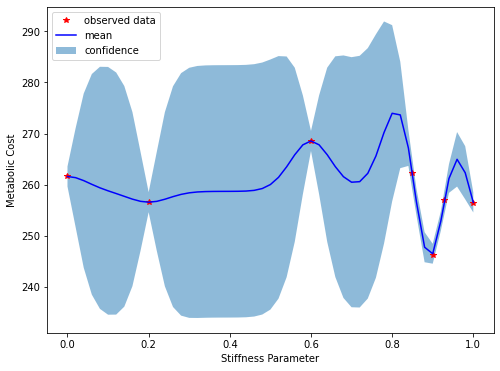

C:\Users\sidda\AppData\Roaming\Python\Python39\site-packages\scipy\io\matlab\_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


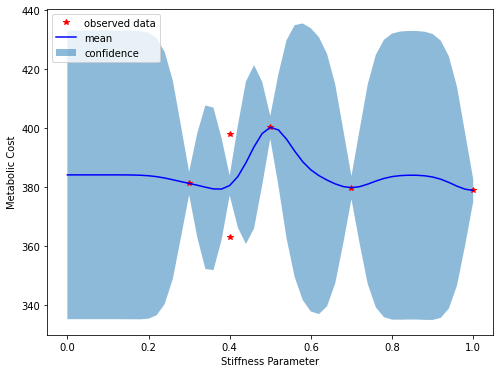

C:\Users\sidda\AppData\Roaming\Python\Python39\site-packages\scipy\io\matlab\_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


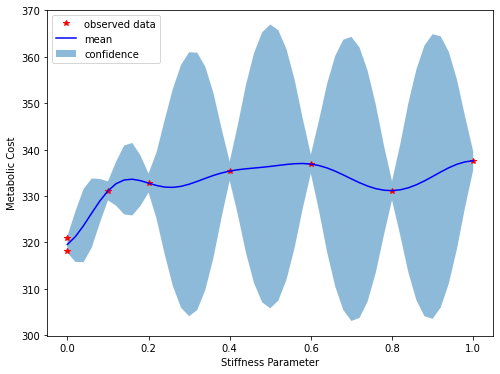

In [353]:
from botorch.utils.transforms import normalize, unnormalize
import matplotlib.pyplot as plt
from scipy.io import loadmat
from gpytorch.kernels import RBFKernel
from plotting_gp import plotting_gp
BOUNDS = torch.tensor([[50], [150]], dtype=dtype, device=device)
noise_std=0.1
base_model_list=[]

sub1_1 = loadmat('sub_1_speed_1.mat')
train_y=-sub1_1['parms']['yval'][0][0].T
train_y=torch.tensor(train_y,device=device)
train_x_raw=sub1_1['parms']['xval'][0][0][0:train_y.shape[0]]
train_x_raw=torch.tensor(train_x_raw,device=device)
train_x=normalize(train_x_raw,bounds=BOUNDS)
train_yvar = torch.full_like(train_y, noise_std**2)
#print(train_yvar.shape,"yvar")
base_model_1 = get_fitted_model(train_x, train_y, train_yvar)
base_model_1.covar_module.base_kernel.lengthscale = 0.5/math.sqrt(torch.tensor(sub1_1['parms_update'][0,-1]['theta'][0][0])[0,1])
base_model_1.covar_module.outputscale=math.sqrt(torch.tensor(sub1_1['parms_update'][0,-1]['theta'][0][0])[0,0].numpy())
base_model_list.append(base_model_1)
plotting_gp(base_model_1,train_x,train_y,train_yvar,device,BOUNDS)


sub1_1_25 = loadmat('sub_1_speed_1_5.mat')
train_y=-sub1_1_25['parms']['yval'][0][0].T
train_y=torch.tensor(train_y,device=device)
train_x_raw=sub1_1_25['parms']['xval'][0][0][0:train_y.shape[0]]
train_x_raw=torch.tensor(train_x_raw,device=device)
train_x=normalize(train_x_raw,bounds=BOUNDS)
#print(train_y.shape,train_x.shape)
#print(train_x,train_y)
train_yvar = torch.full_like(train_y, noise_std**2)
#print(train_yvar.shape,"yvar")
base_model_2 = get_fitted_model(train_x, train_y, train_yvar)
base_model_2.covar_module.base_kernel.lengthscale = 0.5/math.sqrt(torch.tensor(sub1_1_25['parms_update'][0,-1]['theta'][0][0])[0,1])
base_model_2.covar_module.outputscale=math.sqrt(torch.tensor(sub1_1_25['parms_update'][0,-1]['theta'][0][0])[0,0].numpy())
base_model_list.append(base_model_2)
plotting_gp(base_model_2,train_x,train_y,train_yvar,device,BOUNDS)


sub1_1_5 = loadmat('sub_1_speed_1_25.mat')
train_y=-sub1_1_5['parms']['yval'][0][0].T
train_y=torch.tensor(train_y,device=device)
train_x_raw=sub1_1_5['parms']['xval'][0][0][0:train_y.shape[0]]
train_x_raw=torch.tensor(train_x_raw,device=device)
train_x=normalize(train_x_raw,bounds=BOUNDS)
#print(train_y.shape,train_x.shape)
#print(train_x,train_y)
train_yvar = torch.full_like(train_y, noise_std**2)
#print(train_yvar.shape,"yvar")
true_model = get_fitted_model(train_x, train_y, train_yvar)
true_model.covar_module.base_kernel.lengthscale = 0.5/math.sqrt(torch.tensor(sub1_1_5['parms_update'][0,-1]['theta'][0][0])[0,1])
true_model.covar_module.outputscale=math.sqrt(torch.tensor(sub1_1_5['parms_update'][0,-1]['theta'][0][0])[0,0].numpy())**2
plotting_gp(true_model,train_x,train_y,train_yvar,device,BOUNDS)


    #Y_mean_target=target_model.Y_mean
    #Y_std_target=target_model.Y_std

In [354]:
#BOUNDS = torch.tensor([[0], [1.2]], dtype=dtype, device=device)
BOUNDS = torch.tensor([[50], [150]], dtype=dtype, device=device)
TARGET_SHIFT=0
def f(X, shift=TARGET_SHIFT,iteration=-1):
    """
    Torch-compatible objective function for the target_task
    """
    #f_X = torch.sin(X+2*shift)+(shift+1)*torch.sin(10*(X+shift*0.5)/3)+shift
    #f_X = torch.cos(10 * X+shift) * torch.exp(.2 * X+(shift/10)) + torch.exp(-5 * (X - 1) ** 2+(shift/15))
    # f_X=0
    # for i in range(1,7):
    #     f_X+=i*torch.sin((i+1)*X+2*shift*X+i)+X*shift/3
    # if iteration<0:
    #     f_X=(1.4-3*X+shift)*torch.sin(18*X+shift)
    # else:
    #     f_X=(1.4-3*X+shift+0.5)*torch.sin(18*X+shift+0.5)
    #     print("iteration=",iteration)
    #f_X=(1.4-3*X+shift)*torch.sin(18*X+shift)
    #f_X=-(torch.sin(X+shift/2)+(shift/2+1)*torch.sin(10*X/3)+shift*torch.log10(X)/2-0.84*X+shift/4*X)
    # if iteration>=4:
    #     f_X=torch.exp(-X+shift/2)*torch.sin(2*math.pi*X+shift/2)+shift/2
    # else:
    #     f_X = -torch.sin(X+2*shift)-(shift+1)*torch.sin(10*(X+shift*0.5)/3)-shift
    #f_X=X*torch.sin(X+shift)+shift*X*torch.cos(2*X)

    
    true_model.eval()
    likelihoods=true_model.likelihood
    likelihoods.eval()
    with torch.no_grad():
        observed_preds = likelihoods(true_model(normalize(X,bounds=BOUNDS)),noise=train_yvar)
        observed_pred_means = observed_preds.mean.squeeze(-1)*true_model.Y_std + true_model.Y_mean
        #print(target_model.Y_std,target_model.Y_mean,"mean",Y_std_target,Y_mean_target)
        out = true_model(normalize(X,bounds=BOUNDS))
        #print(X,observed_preds.mean,"fff")
        #f_X=out.mean*target_model.Y_std+target_model.Y_mean
        f_X=observed_pred_means
        #print(f_X)
    
    return f_X.reshape(f_X.shape[1],f_X.shape[0])
    #return f_X

#### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [118]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize

noise_std = 0.05

# Sample data for each base task
data_by_task = {}
shift_c=[-1.4,-1,1,1.5]
#shift_c=[-1.2,0.7]
for j,task in enumerate(shift_c):
    print(task,j)
    num_training_points = 10
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(
        bounds=BOUNDS, n=num_training_points, q=1, seed=int(task)+53888,
    ).squeeze(1)
    # get observed values
    f_x = f(raw_x, task)
    train_y = f_x + noise_std*torch.randn_like(f_x)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # store training data
    data_by_task[j] = {
        # scale x to [0, 1]
        'train_x': normalize(raw_x, bounds=BOUNDS),
        'train_y': train_y,
        'train_yvar': train_yvar,
    }
       

-1.4 0
-1 1
1 2
1.5 3


#### Let's plot the base tasks and the target task function along with the observed points

1.7295294


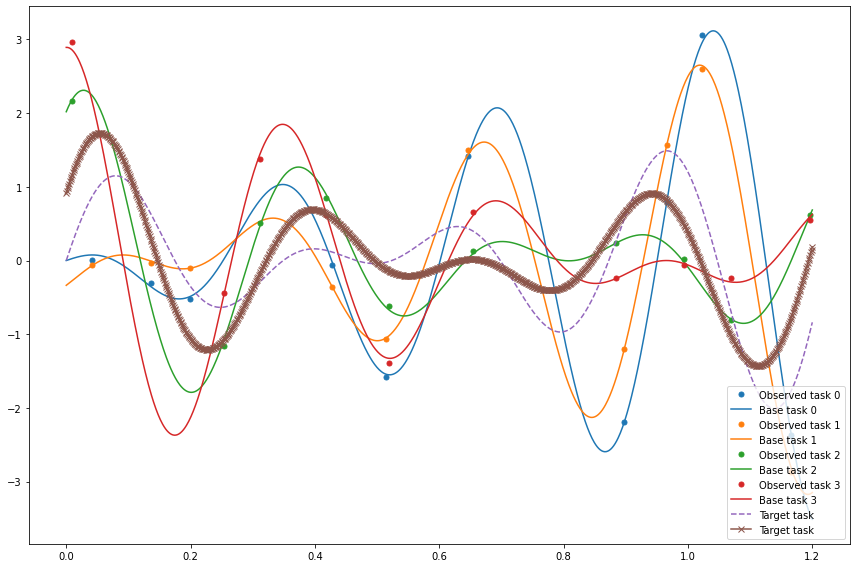

In [126]:
from matplotlib import pyplot as plt

%matplotlib inline

TARGET_SHIFT=0
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = torch.linspace(BOUNDS[0,0],BOUNDS[1,0],1000)
for j,task in enumerate(shift_c):
    # #plot true function and observed values for base runs
    t = ax.plot(
        unnormalize(data_by_task[j]['train_x'], bounds=BOUNDS).cpu().numpy(),
        data_by_task[j]['train_y'].cpu().numpy(),
        '.',
        markersize=10,
        label=f"Observed task {j}",
    )
    ax.plot(
        x.detach().numpy(),
        f(x, task).cpu().numpy(),
        label=f"Base task {j}",
        color=t[0].get_color(), 
    )
# plot true target function
ax.plot(
    x.detach().numpy(),
    f(x,TARGET_SHIFT).detach().numpy(),
    '--',
    label="Target task",

)
ax.plot(
    x.detach().numpy(),
    f(x,TARGET_SHIFT,5).detach().numpy(),
    '-x',
    label="Target task",

)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()
print(f(x,TARGET_SHIFT,5).detach().numpy().max())

### Fit base task models

First, let's define a helper function to fit a FixedNoiseGP with an fixed observed noise level.

In [191]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP,SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import RBFKernel,ScaleKernel
from gpytorch.priors import MultivariateNormalPrior,GammaPrior,NormalPrior

def get_fitted_model(train_X, train_Y, train_Yvar, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model 
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    #print(train_X.shape,train_Y.shape)
    #print(Y_std,Y_mean,"fitting")
    model = FixedNoiseGP(train_X, (train_Y - Y_mean)/Y_std,train_Yvar,
            covar_module=ScaleKernel(base_kernel=RBFKernel(lengthscale_prior=NormalPrior(0.08,3.16))
            ,outputscale_prior=NormalPrior(9.48,3.16)))
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    if state_dict is None:
        mll= ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
        fit_gpytorch_model(mll)
    else:
        model.load_state_dict(state_dict)
    return model

#### Now let's fit a FixedNoiseGP for each base task

In [463]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

# suppress GPyTorch warnings about adding jitter
import warnings
warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)

best_rgpe_all = []
best_random_all = []
best_vanilla_nei_all = []
N_BATCH = 10 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 128 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
MC_SAMPLES = 64 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 256 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1

# Fit base model
base_model_list = []
for j,task in enumerate(shift_c):
    print(f"Fitting base model {j},",task)
    # Average over multiple trials
    best_vanilla_nei = []
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=278+j).squeeze(1)    
    train_x = normalize(raw_x, bounds=BOUNDS)
    #train_x=raw_x
    train_y_noiseless = f(raw_x,task)
    train_y = train_y_noiseless + noise_std*torch.randn_like(train_y_noiseless)
    train_yvar = torch.full_like(train_y, noise_std**2)
    vanilla_nei_train_x = train_x.clone()
    vanilla_nei_train_y = train_y.clone()
    vanilla_nei_train_yvar = train_yvar.clone()
    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    vanilla_nei_best_value = best_value
    best_vanilla_nei.append(vanilla_nei_best_value)
    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH): 
        #print(best_value)
        # Run Vanilla NEI for comparison
        vanilla_nei_model = get_fitted_model(
            vanilla_nei_train_x, 
            vanilla_nei_train_y, 
            vanilla_nei_train_yvar,
        )
        vanilla_nei_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        vanilla_qNEI = qNoisyExpectedImprovement(
            model=vanilla_nei_model, 
            X_baseline=vanilla_nei_train_x,
            sampler=vanilla_nei_sampler,
        )
        vanilla_nei_candidate, _ = optimize_acqf(
            acq_function=vanilla_qNEI,
            bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
            #bounds=BOUNDS,
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # fetch the new values 
        vanilla_nei_new_x = vanilla_nei_candidate.detach()
        vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS),task)
        #vanilla_nei_new_y_noiseless = f(vanilla_nei_new_x)
        vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std*torch.randn_like(vanilla_nei_new_y_noiseless)
        vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)

        # update training points
        vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        vanilla_nei_train_yvar = torch.cat([vanilla_nei_train_yvar, vanilla_nei_new_yvar])
        # get the new best observed value
        vanilla_nei_best_value = vanilla_nei_train_y.max().item()
        best_vanilla_nei.append(vanilla_nei_best_value)
    # plt.plot(vanilla_nei_train_x.cpu().numpy(), vanilla_nei_train_y.cpu().detach(),'.')
    # plt.show()
    vanilla_nei_model_final = get_fitted_model(vanilla_nei_train_x, 
                        vanilla_nei_train_y, 
                        vanilla_nei_train_yvar,
                        )
    vanilla_nei_model_final.eval()
    likelihood=vanilla_nei_model_final.likelihood
    likelihood.eval()
    # Test points are regularly spaced along Bounds
    # Make predictions by feeding model through likelihood
        # vanilla_nei_model.eval()
        # likelihood=vanilla_nei_model.likelihood
        # likelihood.eval()
  
    with torch.no_grad():
        test_x = torch.linspace(0,1, 51).to(device)
        observed_pred = likelihood(vanilla_nei_model_final(test_x),noise=vanilla_nei_train_yvar)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        observed_pred_mean = observed_pred.mean.squeeze(-1)*vanilla_nei_model_final.Y_std + vanilla_nei_model_final.Y_mean
        lower=lower*vanilla_nei_model_final.Y_std + vanilla_nei_model_final.Y_mean
        upper=upper*vanilla_nei_model_final.Y_std + vanilla_nei_model_final.Y_mean
        # Plot training data as black stars
        ax.plot(vanilla_nei_train_x.cpu().numpy(), vanilla_nei_train_y.cpu().numpy(), 'r*',label='observed data')
        # Plot predictive means as blue line
        ax.plot(test_x.cpu().numpy(), observed_pred_mean.cpu().numpy()[0,:], 'b',label='mean')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy()[-1,:], upper.cpu().numpy()[-1,:], alpha=0.5,label='confidence')
        x=torch.linspace(BOUNDS[0,0],BOUNDS[1,0],100)
        ax.plot(normalize(x,bounds=BOUNDS.cpu()).detach().numpy(),f(x,task).cpu().numpy(),color='k',label='base fn')
        ax.legend()
        plt.show()
    base_model_list.append(vanilla_nei_model)  

Fitting base model 0, -1.4


TypeError: __init__() missing 1 required positional argument: 'train_Yvar'

### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [78]:
def roll_col(X, shift):  
    """
    Rotate columns to right by shift.
    """
    #print(torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1))
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [79]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.
    
    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    #print(n,"n")
    #print(f_samps.shape,"fsamps shape")
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1), 
            target_y.squeeze(-1),
        ).view(n, n, 2)
        #print(cartesian_y)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = (
            (f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps) ^
            (cartesian_y[..., 0] < cartesian_y[..., 1])
        ).sum(dim=-1).sum(dim=-1)
        #print(rank_loss,"rankloss") 
    else:
        rank_loss = torch.zeros(f_samps.shape[0], dtype=torch.long, device=target_y.device)
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        #print(y_stack,"ystack")
        #print(f_samps,"fsamps")
        for i in range(1,target_y.shape[0]):
            rank_loss += (
                (roll_col(f_samps, i) > f_samps) ^ (roll_col(y_stack, i) > y_stack)
            ).sum(dim=-1)
        #print(rank_loss,"rankloss") 
    return rank_loss

Define a function to:
1. Create a batch mode-gp LOOCV GP using the hyperparameters from `target_model`
2. Draw a joint sample across all points from the target task (in-sample and out-of-sample)

In [80]:
def get_target_model_loocv_sample_preds(train_x, train_y, yvar, target_model, num_samples):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.
    
    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw
    
    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    train_yvar_cv = torch.stack([yvar[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {
        name: t.expand(batch_size, *[-1 for _ in range(t.ndim)])
        for name, t in state_dict.items()
    }
    model = get_fitted_model(train_x_cv, train_y_cv, train_yvar_cv)#, state_dict=state_dict_expanded)
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(num_samples=num_samples)
        return sampler(posterior).squeeze(-1)

In [81]:
def compute_rank_weights(train_x,train_y,yvar, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using 
        LOOCV for the target model). Note: This implementation does not currently 
        address weight dilution, since we only have a small number of base models.
    
    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples
    
    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        #print(task,"task")
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        #print(posterior)
        sampler = SobolQMCNormalSampler(num_samples=num_samples)
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        #print(base_f_samps.shape,task)
        #base_f_samps is the other models prediction at train_X
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps

    target_f_samps = get_target_model_loocv_sample_preds(
        train_x, train_y, yvar, target_model, num_samples,
    )
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    #print(ranking_loss_tensor,"stack")
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = best_models.bincount(minlength=len(ranking_losses)).type_as(train_x) / num_samples
    #print(best_models,"bm")
    #print(best_models.bincount(minlength=len(ranking_losses)),"binc")
    #print(rank_weights,"rw")
    return rank_weights

In [82]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an 
        interface for GPyTorch models in botorch.
    """
    _num_outputs = 1  # metadata for botorch
    
    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        # print(self.batch_shape)
        self.to(weights)
        
    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()
        
        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # unstandardize predictions
            posterior_mean = posterior.mean.squeeze(-1)*model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

### Optimize target function using RGPE + qNEI

Trial 1 of 1


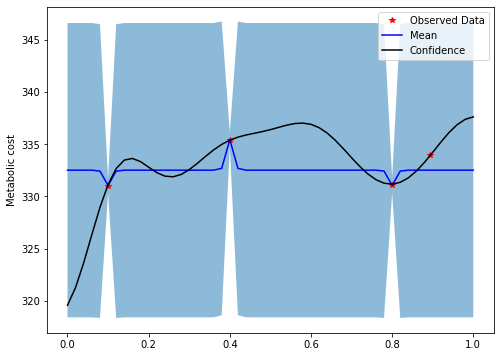

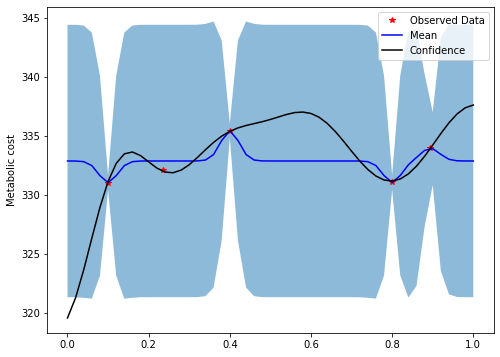

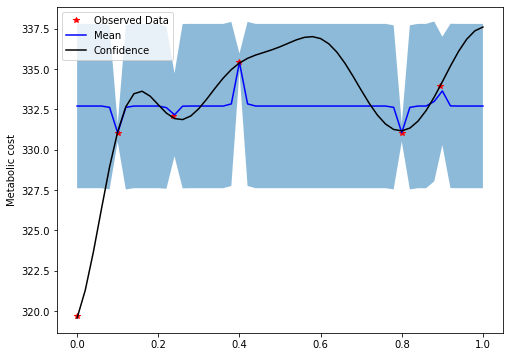

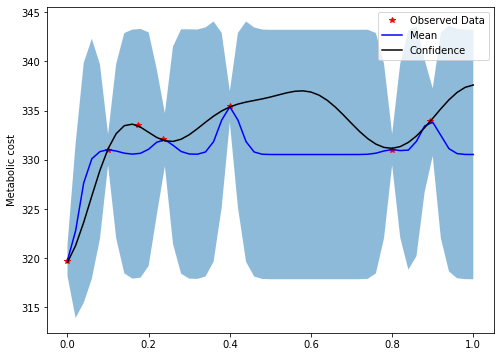

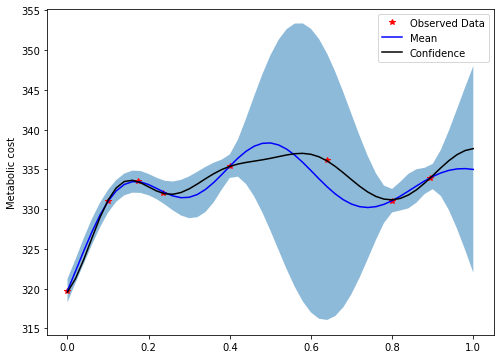

Aquisition function is qNEI


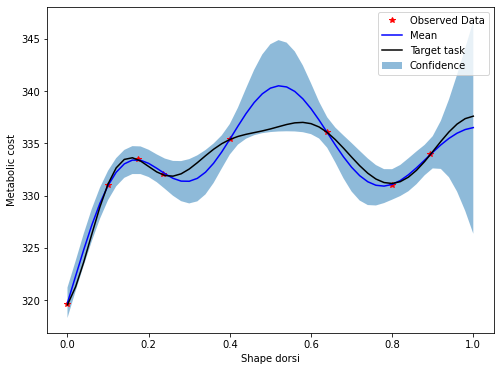

In [351]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement, PosteriorMean, ProbabilityOfImprovement
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
import numpy as np
# suppress GPyTorch warnings about adding jitter
import warnings
import time
device="cuda"
warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)

best_rgpe_acq=[]
train_x_all=[]
vanilla_nei_train_x_all=[]
train_y_all=[]
vanilla_nei_train_y_all=[]
N_BATCH = 5 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 128 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
N_TRIALS = 1 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 256 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1
inter=2
qNEI = qNoisyExpectedImprovement
qMES=qMaxValueEntropy
EI=ExpectedImprovement
PM=PosteriorMean
PI=ProbabilityOfImprovement
prev_time=time.time()
acqui_func={'qNEI':qNEI}#,'EI':EI,'PM':PM,'PI':PI}
# Average over multiple trials
for expl in acqui_func.keys():
    rank_weights_all=[]
    best_rgpe_all = []
    inter_best_rgpe_all=[]
    best_vanilla_nei_all = []

    sampler_qnei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)

    for trial in range(1,N_TRIALS+1):
        print(f"Trial {trial} of {N_TRIALS}")
        best_rgpe = []
        inter_best_rgpe=[]
        best_random = [] 
        best_vanilla_nei = []
        ranking_weights=[]
        # Initial random observations
        
        #raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1,seed=trial+5600).squeeze(1)
        raw_x=torch.tensor(sub1_1_5['parms']['exploration'][0][0],dtype=dtype,device=device).view(-1,1)
        train_x = normalize(raw_x, bounds=BOUNDS)
        #train_x=raw_x
        train_y_noiseless = f(raw_x,TARGET_SHIFT,-1)
    
        train_y = train_y_noiseless + noise_std*torch.randn_like(train_y_noiseless)
        #print(train_x.shape,train_y.shape,"var")
        train_yvar = torch.full_like(train_y, noise_std**2)
        vanilla_nei_train_x = train_x.clone()
        vanilla_nei_train_y = train_y.clone()
        vanilla_nei_train_yvar = train_yvar.clone()
        # keep track of the best observed point at each iteration
        best_value = train_y.max().item()
        best_rgpe.append(best_value)
        best_random.append(best_value)
        vanilla_nei_best_value = best_value
        best_vanilla_nei.append(vanilla_nei_best_value)
        # Run N_BATCH rounds of BayesOpt after the initial random batch
        for iteration in range(N_BATCH): 

            #print(train_x.shape,train_y.shape,"sfead")
            target_model = get_fitted_model(train_x, train_y, train_yvar)
            model_list = base_model_list + [target_model]
            rank_weights = compute_rank_weights(
                train_x, 
                train_y,
                train_yvar, 
                base_model_list, 
                target_model, 
                NUM_POSTERIOR_SAMPLES,
            )
            target_model.train()
            #print(target_model.covar_module.lengthscale)
            ranking_weights.append(rank_weights)
            #print(rank_weights.shape,"rshape")
            # create model and acquisition function
            rgpe_model = RGPE(model_list, rank_weights)
            #rgpe_model.batch_shape = torch.Tensor([])
            
            # optimize
            sampler_qnei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
            # qNEI = qNoisyExpectedImprovement(
            # model=rgpe_model, 
            # X_baseline=train_x,
            # sampler=sampler_qnei,
            # )
            # qMES=qMaxValueEntropy(rgpe_model,candidate_set=train_x)
            # EI=ExpectedImprovement(rgpe_model,best_f=best_value)
            # PM=PosteriorMean(rgpe_model)
            # PI=ProbabilityOfImprovement(rgpe_model,best_f=best_value)
            if expl == 'EI' or expl=='PI':
                aq = acqui_func[expl](rgpe_model, best_f=best_value)
            elif expl=='qNEI':
                aq = acqui_func[expl](rgpe_model,X_baseline=train_x,sampler=sampler_qnei)
            elif expl =='PM':
                aq = acqui_func[expl](rgpe_model)
            elif expl =='qMES':
                candidate_set = torch.linspace(0, 1, 50)
                #print(candidate_set.shape,train_x.shape)
                aq= acqui_func[expl](rgpe_model,candidate_set=candidate_set)
            #print(train_x.shape,train_y.shape)
            candidate, _ = optimize_acqf(
                acq_function=aq,
                bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
                #bounds=BOUNDS,
                q=Q_BATCH_SIZE,
                num_restarts=N_RESTARTS,
                raw_samples=N_RESTART_CANDIDATES,
            )
            #print(candidate.shape,"c")
            # fetch the new values 
            new_x = candidate.detach()
            new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS),0,iteration)
            #new_y_noiseless=f(new_x)
            new_y = new_y_noiseless + noise_std*torch.randn_like(new_y_noiseless)
            new_yvar = torch.full_like(new_y, noise_std**2)

            # update training points
            train_x = torch.cat((train_x, new_x))
            train_y = torch.cat((train_y, new_y))
            train_yvar = torch.cat((train_yvar, new_yvar))
           
            # get the new best observed value
            best_value = train_y.max().item()
            best_rgpe.append(best_value)
            #print(best_value)
            # print(target_model.covar_module.base_kernel.lengthscale,
            #         target_model.covar_module.outputscale)
            target_model.eval()
            likelihood=target_model.likelihood
            likelihood.eval()
            # Test points are regularly spaced along Bounds
            # Make predictions by feeding model through likelihood
            with torch.no_grad():
                test_x = torch.linspace(0,1 , 51).to(device)
                observed_pred = likelihood(target_model(test_x),noise=train_yvar)
                fig, ax = plt.subplots(1, 1, figsize=(8, 6))

                # Get upper and lower confidence bounds
                lower, upper = observed_pred.confidence_region()
                posterior_mean = observed_pred.mean.squeeze(-1)*target_model.Y_std + target_model.Y_mean
                lower=lower*target_model.Y_std + target_model.Y_mean
                upper=upper*target_model.Y_std + target_model.Y_mean
                # Plot training data as black stars
                ax.plot(train_x.cpu().numpy(), -train_y.cpu().numpy(), 'r*')
                # Plot predictive means as blue line
                ax.plot(test_x.cpu().numpy(), -posterior_mean.cpu().numpy()[0,:], 'b')
                ax.plot(test_x.cpu().detach().numpy(),-true_model_mean.cpu().numpy()[0,:],'k')
                # Shade between the lower and upper confidence bounds
                ax.fill_between(test_x.cpu().numpy(), -lower.cpu().numpy()[-1,:], -upper.cpu().numpy()[-1,:], alpha=0.5,label="Target task")
                ax.set_ylabel("Metabolic cost")
                ax.legend(['Observed Data', 'Mean', 'Confidence'])
                plt.show()

                   

            # Run Vanilla NEI for comparison
        #     vanilla_nei_model = get_fitted_model(
        #         vanilla_nei_train_x, 
        #         vanilla_nei_train_y, 
        #         vanilla_nei_train_yvar,
        #     )
        #     #print(vanilla_nei_model.covar_module.lengthscale,"vanilla")
        #     # vanilla_nei_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        #     # vanilla_qNEI = qNoisyExpectedImprovement(
        #     #     model=vanilla_nei_model, 
        #     #     X_baseline=vanilla_nei_train_x,
        #     #     sampler=vanilla_nei_sampler,
        #     # )
        #     #vanilla_EI=ExpectedImprovement(vanilla_nei_model,best_f=vanilla_nei_best_value)
        #     #vanilla_PM=PosteriorMean(vanilla_nei_model)
        #     vanilla_PI=ProbabilityOfImprovement(vanilla_nei_model,best_f=vanilla_nei_best_value)
        #     vanilla_nei_candidate, _ = optimize_acqf(
        #         acq_function=vanilla_PI,
        #         bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
        #         #bounds=BOUNDS,
        #         q=Q_BATCH_SIZE,
        #         num_restarts=N_RESTARTS,
        #         raw_samples=N_RESTART_CANDIDATES,
        #     )
        #     # fetch the new values 
        #     vanilla_nei_new_x = vanilla_nei_candidate.detach()
        #     vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS),TARGET_SHIFT,iteration)
        #     #vanilla_nei_new_y_noiseless=f(vanilla_nei_new_x)
        #     vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std*torch.randn_like(new_y_noiseless)
        #     vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)

        #     # update training points
        #     vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        #     vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        #     vanilla_nei_train_yvar = torch.cat([vanilla_nei_train_yvar, vanilla_nei_new_yvar])

        #     # get the new best observed value
        #     vanilla_nei_best_value = vanilla_nei_train_y.max().item()
        #     best_vanilla_nei.append(vanilla_nei_best_value)


        # print("RGPE")
        rgpe_model_final=get_fitted_model(train_x,train_y,train_yvar)
        #rgpe_model_final.covar_module.lengthscale=0.05
        likelihood=rgpe_model_final.likelihood
        rgpe_model_final.eval()
        likelihood.eval()
        # Test points are regularly spaced along Bounds
        # Make predictions by feeding model through likelihood
        print("Aquisition function is",expl)
        #print(train_x)
        with torch.no_grad():
            test_x = torch.linspace(0,1 , 51).to(device)
            observed_pred = likelihood(rgpe_model_final(test_x),noise=train_yvar)
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))

            # Get upper and lower confidence bounds
            lower, upper = observed_pred.confidence_region()
            posterior_mean = observed_pred.mean.squeeze(-1)*rgpe_model_final.Y_std + rgpe_model_final.Y_mean
            lower=lower*rgpe_model_final.Y_std + rgpe_model_final.Y_mean
            upper=upper*rgpe_model_final.Y_std + rgpe_model_final.Y_mean
            # Plot training data as black stars
            ax.plot(train_x.cpu().numpy(), -train_y.cpu().numpy(), 'r*')
            # Plot predictive means as blue line
            ax.plot(test_x.cpu().numpy(), -posterior_mean.cpu().numpy()[0,:], 'b')
            # Shade between the lower and upper confidence bounds
            ax.fill_between(test_x.cpu().numpy(), -lower.cpu().numpy()[-1,:], -upper.cpu().numpy()[-1,:], alpha=0.5)
            x = torch.linspace(BOUNDS[0,0],BOUNDS[1,0],1000)
            #ax.plot(normalize(x,bounds=BOUNDS.cpu()).detach().numpy(),f(x, TARGET_SHIFT,100).detach().numpy(),'k')
            ax.plot(test_x.cpu().detach().numpy(),-true_model_mean.cpu().numpy()[0,:],'k')
            ax.set_ylabel("Metabolic cost")
            ax.set_xlabel("Shape dorsi")
            ax.legend(['Observed Data', 'Mean', 'Target task',"Confidence"])
            plt.show()
        rank_weights_all.append(ranking_weights)
        #vanilla_nei_train_x_all.append(vanilla_nei_train_x)
        train_x_all.append(train_x.cpu().numpy()) 
        #vanilla_nei_train_y_all.append(vanilla_nei_train_y)
        train_y_all.append(train_y.cpu().numpy()) 
        best_rgpe_all.append(best_rgpe)
        #inter_best_rgpe_all.append(inter_best_rgpe)
        #best_random_all.append(best_random)
        best_vanilla_nei_all.append(best_vanilla_nei)
    best_rgpe_acq.append(best_rgpe_all)
best_rgpe_acq = np.array(best_rgpe_acq)


In [257]:
print(train_x_all.shape)
print(train_x_best,len(x))

(4, 8, 1)


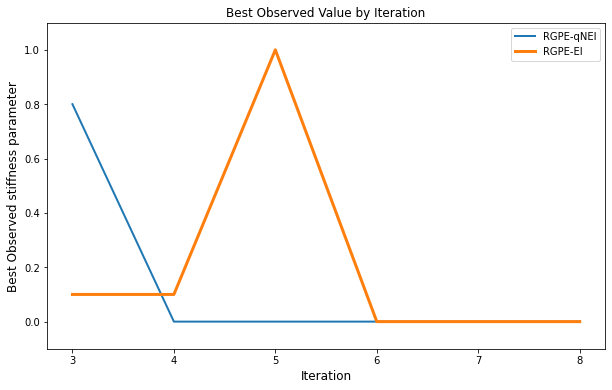

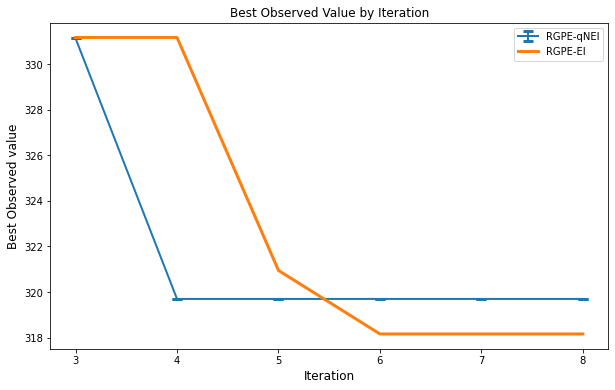

In [345]:
train_x_all=np.array(train_x_all)
train_y_all=np.array(train_y_all)
x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH +1)
y=range(RANDOM_INITIALIZATION_SIZE+inter,RANDOM_INITIALIZATION_SIZE + N_BATCH + 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plt.plot(x,best_rgpe_all.mean(axis=0),label="RGPE-NEI")
# plt.plot(x,best_vanilla_nei_all.mean(axis=0),label="FixedNoiseGP-NEI")

#Plot RGPE - NEI
for j in range(train_x_all.shape[0]):
    train_x_best=[]
    for i in range(2,train_x_all.shape[1]):
        train_x_best.append(train_x_all[j,train_y_all[0,:i+1].argmax(axis=0)][0])
        #print(train_x_best,train_y_all[0,:i+1].argmax(axis=0)[0])
    ax.plot(x,train_x_best,linewidth=2)


# Plot FixedNoiseGP - NEI
# ax.errorbar(
#     x, 
#     -best_vanilla_nei_all.mean(axis=0), 
#     #yerr= best_vanilla_nei_all.std(axis=0) / math.sqrt(N_TRIALS), 
#     label="vanilla BO", 
#     linewidth=3,
#     capsize=5,
#     capthick=3,
# )
train_y=sub1_1_5['parms']['yval'][0][0].T
train_x=sub1_1_5['parms']['xval'][0][0]
train_y=torch.tensor(train_y)[1:]
#print(train_y.shape,train_y)
best_true_y=[]
best_true_x=[]
for i in range(1,len(train_y)):
    best_true_y.append(train_y[:i+1].min())
    best_true_x.append(train_x[train_y[:i+1].argmin()])
best_true_x=torch.Tensor(np.array(best_true_x))
best_true_x=normalize(best_true_x,bounds=BOUNDS.cpu())
ax.errorbar(x,best_true_x,label="vanilla BO",linewidth=3)

# ## intermediate
# ax.errorbar(
#     y, 
#     inter_best_rgpe_all.mean(axis=0), 
#     yerr= inter_best_rgpe_all.std(axis=0) / math.sqrt(N_TRIALS), 
#     label="Inter-RGPE - NEI", 
#     linewidth=3, 
#     capsize=5,
#     capthick=3,
# )
#ax.set_ylim(bottom=0)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Observed stiffness parameter', fontsize=12)
ax.set_ylim([-0.1,1.1])
ax.set_title('Best Observed Value by Iteration', fontsize=12)
labels=["RGPE-qNEI","RGPE-EI","RGPE-PM","RGPE-PI","vanilla BO-EI"]
ax.legend(labels,loc="upper right", fontsize=10)
plt.show()
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
for i in range(best_rgpe_acq.shape[0]):
    ax1.errorbar(
        x, 
        -best_rgpe_acq.mean(axis=1)[:len(x)][i,:], 
        yerr= best_rgpe_acq.std(axis=1)[:len(x)][i,:] / math.sqrt(N_TRIALS), 
        linewidth=2, 
        capsize=5,
        capthick=3,
    )
ax1.errorbar(x,best_true_y,label="vanilla BO",linewidth=3)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Best Observed value', fontsize=12)
#ax.set_ylim([0,1])
ax1.set_title('Best Observed Value by Iteration', fontsize=12)
labels=["RGPE-qNEI","RGPE-EI","RGPE-PM","RGPE-PI","vanilla BO-EI"]
ax1.legend(labels,loc="upper right", fontsize=10)
plt.show()




In [337]:
print(len(x),len(best_true_y),best_rgpe_acq.shape,len(train_y))

4 6 (4, 1, 4) 7


In [267]:
best_true_x=torch.Tensor(np.array(best_true_x))
best_true_x=normalize(best_true_x,bounds=BOUNDS.cpu())

#### Plot best observed value vs iteration

In [204]:
best_true_y=[]
best_true_x=[]
for i in range(2,len(train_y)):
    best_true_y.append(train_y[:i+1].argmin())
    best_true_x.append(train_x[train_y[:i+1].argmin()])

In [258]:
print(len(x))

7


In [205]:
print(best_true_x)

[tensor([0.1000], device='cuda:0', dtype=torch.float64), tensor([0.1000], device='cuda:0', dtype=torch.float64), tensor([0.1610], device='cuda:0', dtype=torch.float64), tensor([0.1610], device='cuda:0', dtype=torch.float64), tensor([0.1610], device='cuda:0', dtype=torch.float64), tensor([0.1610], device='cuda:0', dtype=torch.float64)]


In [203]:
print((best_true_y))

[tensor(0), tensor(0), tensor(4), tensor(4), tensor(4), tensor(4)]


In [130]:
print(train_y)

tensor([[256.5380],
        [268.5737],
        [246.1142],
        [256.4377],
        [262.2892],
        [256.9540],
        [261.5879]], dtype=torch.float64)
